# Problem Description
In this problem, you will forecast the outcome of a portfolio of loans. Each loan is scheduled to be repaid over 3 years and is structured as follows:

#### Dataset
Each row corresponds to a loan, and the columns are defined as follows:

- The column with header `days since origination` indicates the number of days that elapsed between origination and the date when the data was collected.
- For loans that charged off before the data was collected, the column with header `days from origination to chargeoff` indicates the number of days that elapsed between origination and chargeoff.

#### Goal
We would like you to estimate **what fraction of these loans will have charged off by the time all of their 3-year terms are finished**.

# Exploratory Data Analysis
## Feature Engineering
#### Load libraries & Read data

In [39]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from scipy.optimize import curve_fit

In [13]:
data = pd.read_csv('loan_timing.csv', header = 0)

Now I created a new column called **`chargeoff`** which is a dummy variable, where 1 means that loan has charged off and 0 otherwise. This can be used as the response variable if we want to build a model later.

I also created a column called **`prop`**, which stores the fraction of loans that have charged off within that value of `days since origination`. For example, if `days since origination` equals 360, then 

$$prop = \frac{\text{number of chargeoffs with `days since origination`} < 360}{\text{number of total loans with `days since origination`}< 360}$$.

In [17]:
# new column
data['chargeoff'] = np.where(data['days from origination to chargeoff'] >= 0, 1, 0)

# another new column
prop = []
for index, row in data.iterrows():
    prop.append(float(data[(data["days since origination"] <= row["days since origination"]) & (data["chargeoff"] == 1)].shape[0])/float(data[data["days since origination"] <= row["days since origination"]].shape[0]))
    
data["prop"] = prop

Now let's look at part of the dataset. Take record 15 as an example, `prop = 0.0398` means among those loans with `days since origination` less than or equal to 400, 3.98% of them have charged off.

In [65]:
data[11:16]

,days since origination,days from origination to chargeoff,chargeoff,prop
11,336,NaN,0,0.034858
12,51,NaN,0,0.006342
13,117,NaN,0,0.013592
14,327,78.0,1,0.033879
15,400,390.0,1,0.039781


## Simple Visualizations
#### What percentage of loans have been charged off when the data was collected?
We can tell that 3305 out of 50000 loans have been charged off, which is about 6.7%. 

In [183]:
float(data[data["chargeoff"] == 1].shape[0])/ float(data.shape[0])

0.0661

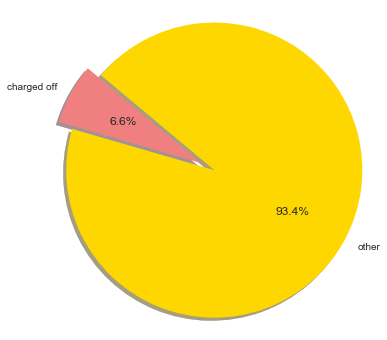

In [184]:
# pie chart
fig, ax = plt.subplots(figsize = (6, 6))
labels = "charged off", "other"
sizes = [3305, 50000 - 3305]
colors = ['lightcoral', 'gold']
explode = (0.1, 0) # explode chargedoff

plt.pie(sizes, explode = explode, labels = labels, colors = colors,
       autopct = '%1.1f%%', shadow = True, startangle = 140)
plt.axis('equal')
plt.show()

#### Chargeoff vs. `days from origination to chargeoff`

Let's also have a look at the distribution of `days from origination to chargeoff`. It seems that the number of chargeoff loans decreases as `days from origination to charge off` increases. However, it doesn't give us too much useful information because we would like to predict the fraction of future chargeoff loans, where we don't have information of `days from origination` at this stage. 

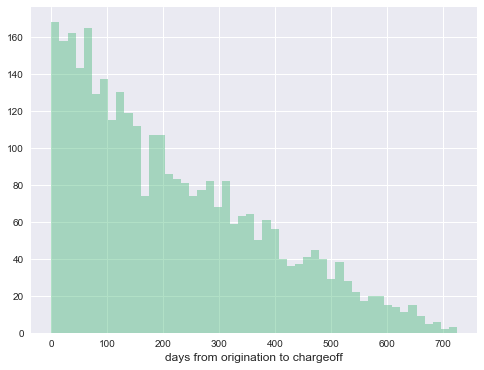

In [186]:
plt.figure(figsize = (8, 6))
sns.distplot(data[data["chargeoff"] == 1]["days from origination to chargeoff"], 
             bins = 50, kde = False, color = "mediumseagreen")
plt.xlabel('days from origination to chargeoff', fontsize = 12)
plt.show()

#### Chargeoff vs. `days since origination`

It seems that the number of chargeoff loans increases as `days since origination` increases. This is useful information for predicting future fraction.

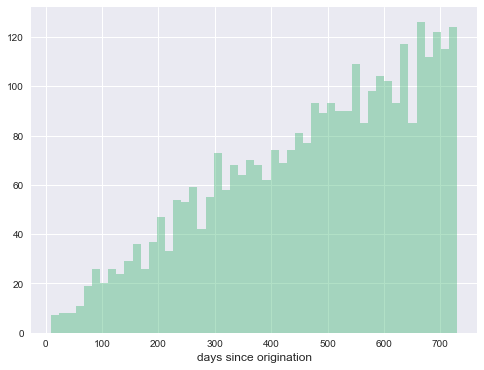

In [187]:
# distribution of loans that charge off
plt.figure(figsize = (8, 6))
sns.distplot(data[data["chargeoff"] == 1]["days since origination"], 
             bins = 50, kde = False, color = "mediumseagreen")
plt.xlabel('days since origination', fontsize = 12)
plt.show()

#### Chargeoff proportion vs. Days since origination
Now let's explore the relationship between our newly created variable: chargeoff proportion and the `days since origination`, which is the information we have for each record.

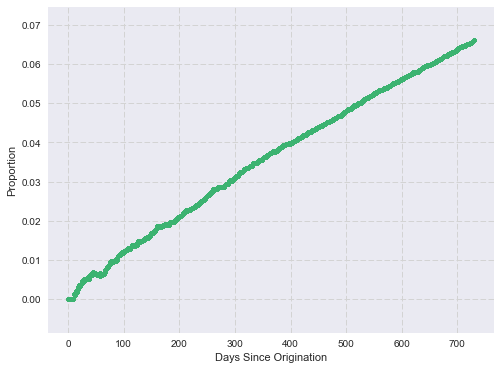

In [190]:
fig, ax = plt.subplots(figsize = (8, 6))
x = data['days since origination']
y = data['prop']
plt.scatter(x, y, s = 10, color = "mediumseagreen")

plt.xlabel('Days Since Origination')
plt.ylabel('Proportion')
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

We could see an almost perfect linear relationship between the two. One thing we could try is simple linear regression. Besides this, some other techniques could also be applied which I will discuss later in the notebook.

#### Chargeoff proportion vs. Days from origination to chargeoff

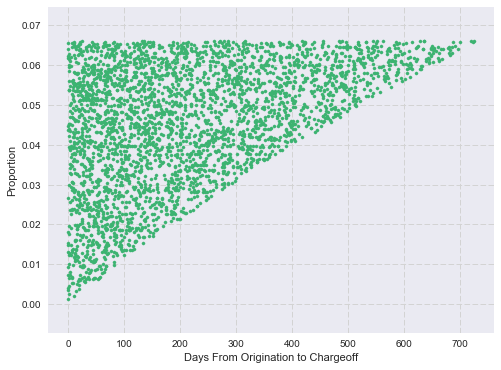

In [192]:
fig, ax = plt.subplots(figsize = (8, 6))
x = data['days from origination to chargeoff']
y = data['prop']
plt.scatter(x, y, s = 10, color = "mediumseagreen")

plt.xlabel('Days From Origination to Chargeoff')
plt.ylabel('Proportion')
plt.grid(color = 'lightgray', linestyle = '--')
plt.show()

I don't see a significant relationship through the scatter plot.

# Model
## Cross-Validation
I only have a single data set here, yet I still want to quantify the quality of a particular fit. In this case, I employ the scikit learn libraries cross-validation implementation, where I split the dataset into a training sample and a testing sample. The training data are used to construct the model, and the testing data quantify the quality of the fit. Here I split our data 60: 40 into training and testing data (60% of the data for training and 40% for testing), before computing a linear regression and visually analyzing the result.

In [156]:
from sklearn.cross_validation import train_test_split
x = data['days since origination']
y = data['prop']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4)

## Simple Linear Regression
### Fit the model
Continue with the result that I found earlier through the scattor plot, the response is `proportion`, and the only predictor is `days since origination`.

Since this is a regression problem with numeric target variable, the metric I chose is MSE - mean squared error between the prediction and actual value.

y = 3.291e-03 + 8.870e-05 x
MSE = 1.300e-06
Our prediction of chargeoff fraction = 10.04%


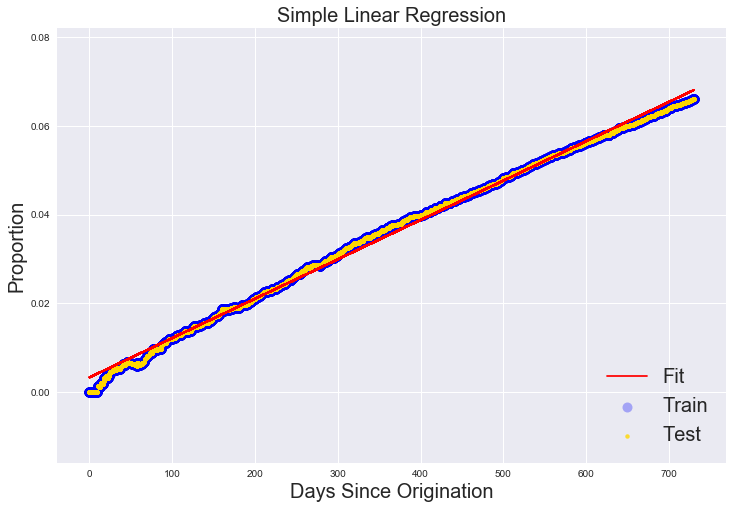

In [157]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train[:, np.newaxis], y_train)

# Plot the data and the model prediction
yf = model.predict(x_test[:, np.newaxis])

plt.figure(figsize = (12, 8))
ax = sns.regplot(x_train, y_train, fit_reg = False, color = 'blue', label = "Train", scatter_kws = {'alpha': 0.3, 's': 100})
ax = sns.regplot(x_test, y_test, fit_reg = False, color = 'gold', label = "Test", scatter_kws = {'s': 20})

# settings
plt.xlabel('Days Since Origination', fontsize = 20)
plt.ylabel('Proportion', fontsize = 20)
plt.title('Simple Linear Regression', fontsize = 20)
plt.plot(x_test, yf, c = 'r', label = "Fit")
ax.legend(loc = 4, fontsize = 20)
sns.despine(offset = 0, trim = True)


print("y = %.3e + %.3e x" % (model.intercept_, model.coef_[0]))
print("MSE = %.3e" % (np.mean((yf - y_test)**2)))
print("Our prediction of chargeoff fraction = " '{percent:.2%}'.format(percent = model.predict(365 * 3)[0]))


The blue points are the training set, yellow points are the test set, red line is our model fit.

### Fit Metrics
The scikit learn library provides several functions that can be used to obtain metrics that quantify the quality of the model fit. For the regression fit, we can use the ***mean absolute error*** and the ***mean squared error***. The second metric can also be used to compute the ***root mean squared error***.

In [158]:
from sklearn import metrics

print("MAE = %.3e" % (metrics.mean_absolute_error(y_test, yf)))
print("MSE = %.3e" % (metrics.mean_squared_error(y_test, yf)))
print("RMSE = %.3e" % (np.sqrt(metrics.mean_squared_error(y_test, yf))))

MAE = 8.971e-04
MSE = 1.300e-06
RMSE = 1.140e-03


## Simple Polynomial Fitting
I will look at the second and third order only.

In [159]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def f(x):
    """ function to approximate by polynomial interpolation"""
    return x * np.sin(x)

### Second order

Degree = 2
MAE = 3.237e-04
MSE = 1.814e-07
RMSE = 4.259e-04
Our prediction of chargeoff fraction = 8.75%


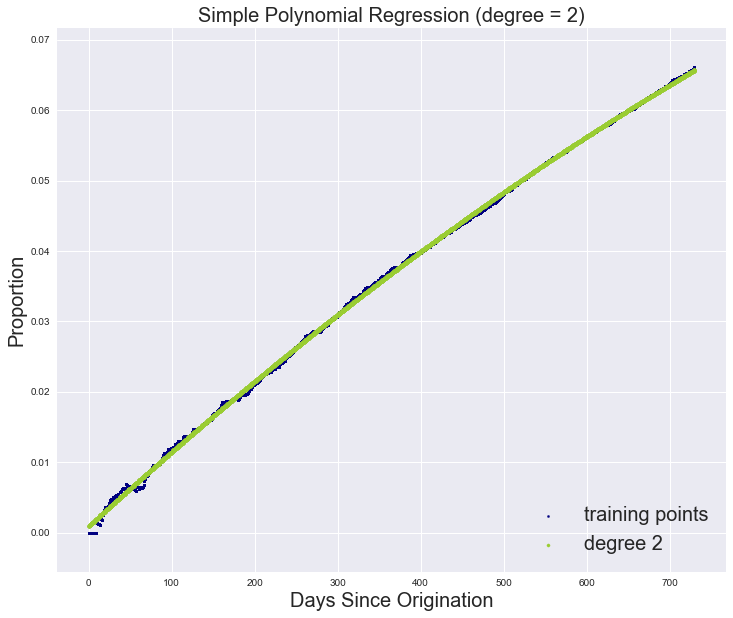

In [160]:
plt.figure(figsize = (12, 10))
plt.scatter(x_train, y_train, color = "navy", s = 5, marker = 'o', label = "training points")

model = make_pipeline(PolynomialFeatures(2), Ridge())
model.fit(x_train[:, np.newaxis], y_train)
yf = model.predict(x_test[:, np.newaxis])

print("Degree = %d" % (2))
print("MAE = %.3e" % (metrics.mean_absolute_error(y_test, yf)))
print("MSE = %.3e" % (metrics.mean_squared_error(y_test, yf)))
print("RMSE = %.3e" % (np.sqrt(metrics.mean_squared_error(y_test, yf))))
print("Our prediction of chargeoff fraction = " '{percent:.2%}'.format(percent = model.predict(365 * 3)[0]))

plt.scatter(x_test, yf, color = "yellowgreen", label = "degree %d" % 2, s = 8)

# settings
plt.xlabel('Days Since Origination', fontsize = 20)
plt.ylabel('Proportion', fontsize = 20)
plt.title('Simple Polynomial Regression (degree = 2)', fontsize = 20)

plt.legend(loc = 4, fontsize = 20)
sns.despine(offset = 0, trim = True)

plt.show()

### Third Order

Degree = 3
MAE = 3.053e-04
MSE = 1.696e-07
RMSE = 4.118e-04
Our prediction of chargeoff fraction = 9.24%


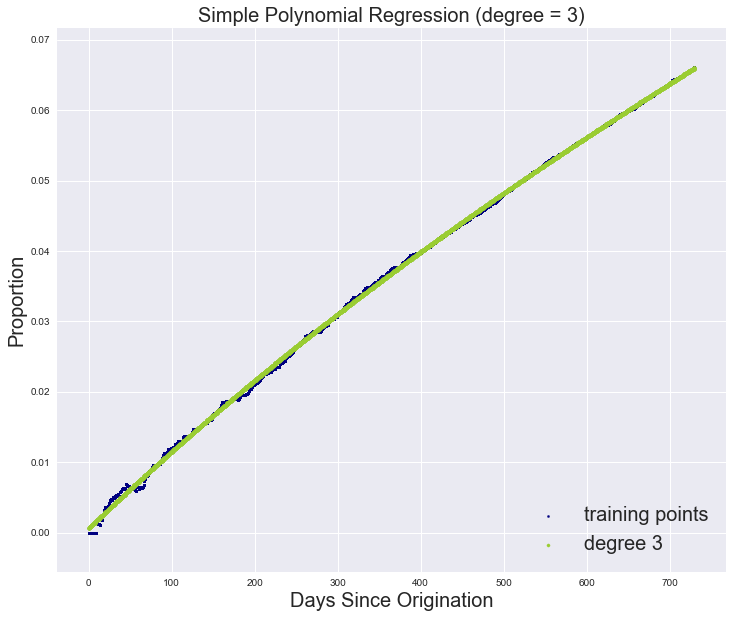

In [161]:
plt.figure(figsize = (12, 10))
plt.scatter(x_train, y_train, color = "navy", s = 5, marker = 'o', label = "training points")

model = make_pipeline(PolynomialFeatures(3), Ridge())
model.fit(x_train[:, np.newaxis], y_train)
yf = model.predict(x_test[:, np.newaxis])

print("Degree = %d" % (3))
print("MAE = %.3e" % (metrics.mean_absolute_error(y_test, yf)))
print("MSE = %.3e" % (metrics.mean_squared_error(y_test, yf)))
print("RMSE = %.3e" % (np.sqrt(metrics.mean_squared_error(y_test, yf))))
print("Our prediction of chargeoff fraction = " '{percent:.2%}'.format(percent = model.predict(365 * 3)[0]))

plt.scatter(x_test, yf, color = "yellowgreen", label = "degree %d" % 3, s = 8)

# settings
plt.xlabel('Days Since Origination', fontsize = 20)
plt.ylabel('Proportion', fontsize = 20)
plt.title('Simple Polynomial Regression (degree = 3)', fontsize = 20)

plt.legend(loc = 4, fontsize = 20)
sns.despine(offset = 0, trim = True)

plt.show()

### 10th Order

I also look at an extreme case with degree = 10, which tends to overfit the data.

Degree = 10
MAE = 2.202e-04
MSE = 9.927e-08
RMSE = 3.151e-04
Our prediction of chargeoff fraction = -7415.15%


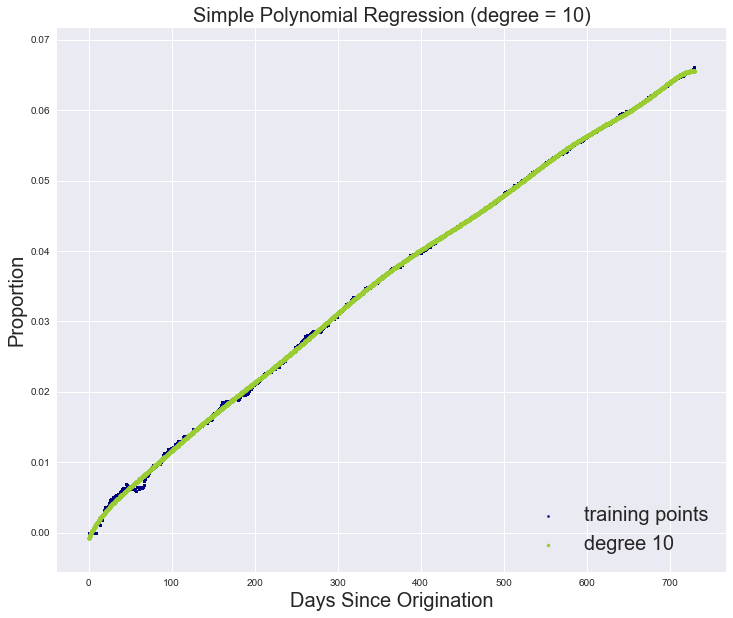

In [165]:
plt.figure(figsize = (12, 10))
plt.scatter(x_train, y_train, color = "navy", s = 5, marker = 'o', label = "training points")

model = make_pipeline(PolynomialFeatures(10), Ridge())
model.fit(x_train[:, np.newaxis], y_train)
yf = model.predict(x_test[:, np.newaxis])

print("Degree = %d" % (10))
print("MAE = %.3e" % (metrics.mean_absolute_error(y_test, yf)))
print("MSE = %.3e" % (metrics.mean_squared_error(y_test, yf)))
print("RMSE = %.3e" % (np.sqrt(metrics.mean_squared_error(y_test, yf))))
print("Our prediction of chargeoff fraction = " '{percent:.2%}'.format(percent = model.predict(365 * 3)[0]))

plt.scatter(x_test, yf, color = "yellowgreen", label = "degree %d" % 10, s = 8)

# settings
plt.xlabel('Days Since Origination', fontsize = 20)
plt.ylabel('Proportion', fontsize = 20)
plt.title('Simple Polynomial Regression (degree = 10)', fontsize = 20)

plt.legend(loc = 4, fontsize = 20)
sns.despine(offset = 0, trim = True)

plt.show()

Although the green line perfectly fits the training points, the model overfits the data, which can be reflected from the negative prediction values which was impossible in our case.

## K Nearest Neighbor Regressor

Model: KNN
MAE = 6.414e-19
MSE = 3.859e-36
RMSE = 1.964e-18
Our prediction of chargeoff fraction = 6.61%


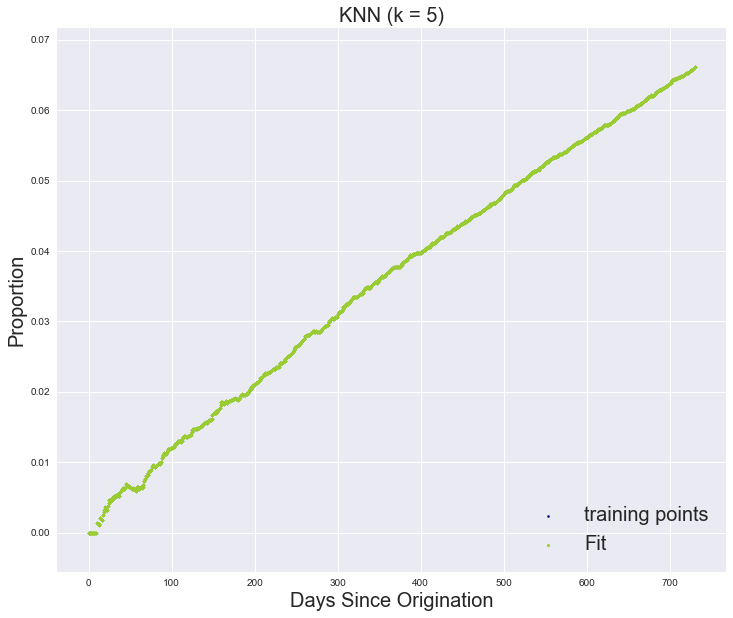

In [179]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors = 5)
neigh.fit(x_train[:, np.newaxis], y_train)
yf = neigh.predict(x_test[:, np.newaxis])

print("Model: KNN")
print("MAE = %.3e" % (metrics.mean_absolute_error(y_test, yf)))
print("MSE = %.3e" % (metrics.mean_squared_error(y_test, yf)))
print("RMSE = %.3e" % (np.sqrt(metrics.mean_squared_error(y_test, yf))))
print("Our prediction of chargeoff fraction = " '{percent:.2%}'.format(percent = neigh.predict(365 * 3)[0]))

plt.figure(figsize = (12, 10))
plt.scatter(x_train, y_train, color = "navy", s = 5, marker = 'o', label = "training points")
plt.scatter(x_test, yf, color = "yellowgreen", label = "Fit", s = 8)

# settings
plt.xlabel('Days Since Origination', fontsize = 20)
plt.ylabel('Proportion', fontsize = 20)
plt.title('KNN (k = 5)', fontsize = 20)

plt.legend(loc = 4, fontsize = 20)
sns.despine(offset = 0, trim = True)

plt.show()

In [180]:
y_test.head()

20982    0.023600
18819    0.044651
6828     0.020646
49822    0.052252
39228    0.065887
Name: prop, dtype: float64